# SYBA - comparison with other methods

## Requirments
We compared SYBA with SAScore (https://github.com/rdkit/rdkit/tree/master/Contrib/SA_Score), SCScore (https://github.com/connorcoley/scscore) and random forest trained within scikit-learn framework so these packages have to be installed. RDKit is needed for all models (SYBA, SAScore, SCScore, RF). To run this notebook is also needed Jupyter.

To obtain SAScore and SCScore, you have to download them from repositories and add them to PYTHONPATH before running Jupyter:
```bash
export PYTHONPATH=PATH_TO_SASCORE:PATH_TO_SCSCORE:$PYTHONPATH
jupyter notebook
```

In [1]:
from sklearn.externals import joblib
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules+
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
import gzip
import os

/home/milan/miniconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
import sascorer as sa
from sklearn.ensemble import RandomForestClassifier

# How models predict scores or classes

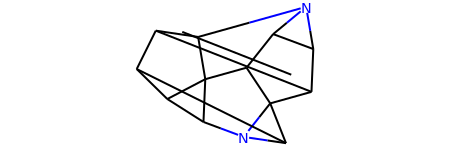

In [3]:
smi = "C12C3N1C1C4=C3C35C6C4C4C(N36)C14C25"
mol = Chem.MolFromSmiles(smi)
Chem.MolFromSmiles(smi)

## SYBA

In [4]:
syba = SybaClassifier()
syba.fitDefaultScore()
syba.predict(smi)

-60.86762700982583

## SAScore

In [5]:
sa.calculateScore(mol)

7.4766997119046525

## SCScore

In [6]:
scscore = SCScorer()
scscore.restore()
scscore.get_score_from_smi(smi)[1]

Restored variables from /home/milan/workspace/nonaccesible_chemical_space_phase3/src/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.pickle


3.0544092099974898

## Random forest

Random forest classifier is trained on 1024-bit fingerprints (model can't be shared within this repository due to its enormous size 1.6GB)

In [7]:
nBits = 1024
if not os.path.exists("../data/rf.pkl"):
    syn_fps = [Chem.GetMorganFingerprintAsBitVect(spls[0],2,nBits=nBits) for spls in SmiMolSupplier(gzip.open("../data/structures_2.csv.gz", mode="rt"), header=True, smi_col=1)]
    syn_classes = [1 for x in range(len(syn_fps))]
    non_fps = [Chem.GetMorganFingerprintAsBitVect(spls[0],2,nBits=nBits) for spls in SmiMolSupplier(gzip.open("../data/structures_1.csv.gz", mode="rt"), header=True, smi_col=2)]
    non_classes = [0 for x in range(len(non_fps))]
    fps = syn_fps + non_fps
    classes = syn_classes + non_classes

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(fps, classes)
    joblib.dump(clf, "../data/rf.pkl")
else:
    clf = joblib.load("../data/rf.pkl")
    
fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
clf.predict([fp])[0], clf.predict_proba([fp])[0]

/home/milan/miniconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/milan/miniconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(0, array([0.99, 0.01]))

## Prepare result files
### Test files

In [8]:
inpath = "../data/"
outpath = "../out/"
files = ["test_set_mc_syn.csv", "test_set_mc_non.csv", "test_set_cp_syn.csv", "test_set_cp_non.csv"]
for f in files:
    with open(inpath+f) as inp, open(outpath+f, "w") as out:
        header = inp.readline().strip()
        out.write(header)
        out.write(",syba,sascore,scscore,rf_class,rf_prob\n")
        for line in inp:
            idx, smi = line.strip().split(",")
            mol = Chem.MolFromSmiles(smi)
            fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
            out.write("{},{},{},{},{},{},{}\n".format(idx, smi, syba.predict(smi), sa.calculateScore(mol), scscore.get_score_from_smi(smi)[1], clf.predict([fp])[0], clf.predict_proba([fp])[0][1]))

### Training files
This code takes few hours

In [9]:
inpath = "../data/"
outpath = "../out/"
#          INP_FILENAME,      SMI_COL,  OUT_FILENAME
files = [("structures_1.csv.gz", 2, "train_set_non.csv"), ("structures_2.csv.gz", 1, "train_set_syn.csv")]
for f, col, out_filename in files:
    with gzip.open(inpath+f, mode="rt") as inp, open(outpath+out_filename, "w") as out:
        header = inp.readline().strip()
        out.write("idx,smiles,syba,sascore,scscore,rf_class,rf_prob\n")
        for line in inp:
            spls = line.strip().split(",")
            idx, smi = spls[0], spls[col]
            mol = Chem.MolFromSmiles(smi)
            fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
            out.write("{},{},{},{},{},{},{}\n".format(idx, smi, syba.predict(smi), sa.calculateScore(mol), scscore.get_score_from_smi(smi)[1], clf.predict([fp])[0], clf.predict_proba([fp])[0][1]))